# Deep Learning Tutorial
**Includes:** 
- Instructions to use the split functions within in the CoderData package.
- Using a small subset of the BeatAML data to predict the dose_response_value of drug response values. The predictive variables will be transcriptomics, proteomics, and drug structure. \
Note: This small subset does not have high predictive power and as such, this is just meant as a guide for creating your own models.

**Sections:** 
- [Command Line Interactions](#Command-Line-Interactions) 
- [CoderData Split Functions](#CoderData-Split-Functions) 
- [Develop Deep Learning Model](#develop-deep-learning-model)

We will be using functions included in CoderData throughout the tutorial. For more information on functions used from the coderdata package look to the API reference.

Import coderdata, pandas, and numpy

In [2]:
import pandas as pd
import numpy as np
import coderdata as cd

### Command Line Interactions

To view the help and usage message. 

In [2]:
!python -m coderdata.cli

usage: coderdata [-h] [-l | -v] {download} ...

options:
  -h, --help     show this help message and exit
  -l, --list     prints list of available datasets and exits program.
  -v, --version  prints the versions of the coderdata API and dataset and
                 exits the program

commands:
  {download}
    download     subroutine to download datasets. See "coderdata download -h"
                 for more options.


To view the datasets available in the package.

In [3]:
!python -m coderdata.cli -l


Available datasets
------------------

beataml: Beat acute myeloid leukemia (BeatAML) focuses on acute myeloid leukemia tumor data. Data includes drug response, proteomics, and transcriptomics datasets.
bladderpdo: Tumor Evolution and Drug Response in Patient-Derived Organoid Models of Bladder Cancer Data includes transcriptomics, mutations, copy number, and drug response data.
ccle: Cancer Cell Line Encyclopedia (CCLE).
cptac: The Clinical Proteomic Tumor Analysis Consortium (CPTAC) project is a collaborative network funded by the National Cancer Institute (NCI) focused on improving our understanding of cancer biology through the integration of transcriptomic, proteomic, and genomic data.
ctrpv2: Cancer Therapeutics Response Portal version 2 (CTRPv2)
fimm: Institute for Molecular Medicine Finland (FIMM) dataset.
gcsi: The Genentech Cell Line Screening Initiative (gCSI)
gdscv1: Genomics of Drug Sensitivity in Cancer (GDSC) v1
gdscv2: Genomics of Drug Sensitivity in Cancer (GDSC) v2
hc

To view the available arguments of the download function.

In [4]:
!python -m coderdata.cli download -h

usage: coderdata download [-h] [-n DATASET_NAME] [-p LOCAL_PATH] [-o]

options:
  -h, --help            show this help message and exit
  -n DATASET_NAME, --name DATASET_NAME
                        name of the dataset to download (e.g., "beataml").
                        Alternatively, "all" will download the full repository
                        of coderdata datasets. See "coderdata --list" for a
                        complete list of available datasets. Defaults to "all"
  -p LOCAL_PATH, --local_path LOCAL_PATH
                        defines the folder the datasets should be stored in.
                        Defaults to the current working directory if omitted.
  -o, --overwrite       allow dataset files to be overwritten if they already
                        exist.


To download a dataset through CLI.

In [ ]:
!python -m coderdata.cli download -n beataml

Downloaded 'https://ndownloader.figshare.com/files/53779292' to '/tmp/beataml_proteomics.csv.gz' \
Downloaded 'https://ndownloader.figshare.com/files/53779295' to '/tmp/beataml_transcriptomics.csv.gz' \
Downloaded 'https://ndownloader.figshare.com/files/53779304' to '/tmp/beataml_samples.csv' \
Downloaded 'https://ndownloader.figshare.com/files/53779334' to '/tmp/beataml_drug_descriptors.tsv.gz' \
Downloaded 'https://ndownloader.figshare.com/files/53779337' to '/tmp/beataml_drugs.tsv.gz' \
Downloaded 'https://ndownloader.figshare.com/files/53779340' to '/tmp/beataml_experiments.tsv.gz' \
Downloaded 'https://ndownloader.figshare.com/files/53779343' to '/tmp/beataml_mutations.csv.gz' \
Downloaded 'https://ndownloader.figshare.com/files/53779532' to '/tmp/genes.csv.gz' 

Import keras the deep learning framework.
We will be using the keras functional API. This allows us to use multiple inputs in our model.
You may need to install a couple of these dependancies to proceed.

Dependencies needed that are not included in coderdata: 
- tensorflow (Note: Tensorflow is only supported up to the a python version of 3.12)
- rdkit
- matplotlib

In [6]:
import keras
from numpy import loadtxt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator
from keras.models import Model
from keras.layers import Input, Dense, concatenate
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.metrics import MeanAbsoluteError
from keras import layers
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

## Download and View Datasets

To view the available datasets in within the coderdata API

In [7]:
cd.list_datasets()

beataml: Beat acute myeloid leukemia (BeatAML) focuses on acute myeloid leukemia tumor data. Data includes drug response, proteomics, and transcriptomics datasets.
bladderpdo: Tumor Evolution and Drug Response in Patient-Derived Organoid Models of Bladder Cancer Data includes transcriptomics, mutations, copy number, and drug response data.
ccle: Cancer Cell Line Encyclopedia (CCLE).
cptac: The Clinical Proteomic Tumor Analysis Consortium (CPTAC) project is a collaborative network funded by the National Cancer Institute (NCI) focused on improving our understanding of cancer biology through the integration of transcriptomic, proteomic, and genomic data.
ctrpv2: Cancer Therapeutics Response Portal version 2 (CTRPv2)
fimm: Institute for Molecular Medicine Finland (FIMM) dataset.
gcsi: The Genentech Cell Line Screening Initiative (gCSI)
gdscv1: Genomics of Drug Sensitivity in Cancer (GDSC) v1
gdscv2: Genomics of Drug Sensitivity in Cancer (GDSC) v2
hcmi: Human Cancer Models Initiative (HCMI

Download and load the dataset(s) that will be needed. In this example we will be using the beataml dataset.

In [ ]:
cd.download("beataml")

Downloaded 'https://ndownloader.figshare.com/files/53779292' to '/tmp/beataml_proteomics.csv.gz' \
Downloaded 'https://ndownloader.figshare.com/files/53779295' to '/tmp/beataml_transcriptomics.csv.gz' \
Downloaded 'https://ndownloader.figshare.com/files/53779304' to '/tmp/beataml_samples.csv' \
Downloaded 'https://ndownloader.figshare.com/files/53779334' to '/tmp/beataml_drug_descriptors.tsv.gz' \
Downloaded 'https://ndownloader.figshare.com/files/53779337' to '/tmp/beataml_drugs.tsv.gz' \
Downloaded 'https://ndownloader.figshare.com/files/53779340' to '/tmp/beataml_experiments.tsv.gz' \
Downloaded 'https://ndownloader.figshare.com/files/53779343' to '/tmp/beataml_mutations.csv.gz' \
Downloaded 'https://ndownloader.figshare.com/files/53779532' to '/tmp/genes.csv.gz' 

In [ ]:
beataml=cd.load("beataml")

Importing raw data ... \
Importing 'drugs' from /tmp/beataml_drugs.tsv.gz ... DONE \
Importing 'drug_descriptors' from /tmp/beataml_drug_descriptors.tsv.gz ... DONE \
Importing 'experiments' from /tmp/beataml_experiments.tsv.gz ... DONE \
Importing 'mutations' from /tmp/beataml_mutations.csv.gz ... DONE \
Importing 'proteomics' from /tmp/beataml_proteomics.csv.gz ... DONE \
Importing 'samples' from /tmp/beataml_samples.csv ... DONE \
Importing 'transcriptomics' from /tmp/beataml_transcriptomics.csv.gz ... DONE \
Importing 'genes' from /tmp/genes.csv.gz ... DONE \
Importing raw data ... DONE 

To view all the datatypes included with a dataset object use the function below.
The info command allows us to see which data types are included in the beataml dataset object.
We will be using the Transcriptomics, Proteomics, Drugs, and Experiments Data in our example.
In other examples you may want to include the samples data to associate cancer and model type with each sample. However, in the BeatAML data, all data is from Acute Myeloid Leukemia patients.

In [10]:
beataml.types()

['transcriptomics',
 'proteomics',
 'mutations',
 'samples',
 'drugs',
 'experiments',
 'genes']

Note that each datatype have different available arguments. To view all options for each types navigate to the usage page. \
Examples are shown below of viewing a regular dataset and datatype combination and a formatted dataset using `format( )`.

In [11]:
beataml.drugs

,improve_drug_id,chem_name,pubchem_id,formula,weight,InChIKey,canSMILES
0,SMI_43282,cytarabine,6253.0,C9H13N3O5,243.22,UHDGCWIWMRVCDJ-CCXZUQQUSA-N,C1=CN(C(=O)N=C1N)C2C(C(C(O2)CO)O)O
1,SMI_23975,entospletinib,59473233.0,C23H21N7O,411.50,XSMSNFMDVXXHGJ-UHFFFAOYSA-N,C1COCCN1C2=CC=C(C=C2)NC3=NC(=CN4C3=NC=C4)C5=CC...
2,SMI_10282,nutlin 3a,11433190.0,C30H30Cl2N4O4,581.50,BDUHCSBCVGXTJM-WUFINQPMSA-N,CC(C)OC1=C(C=CC(=C1)OC)C2=NC(C(N2C(=O)N3CCNC(=...
3,SMI_56581,akt inhibitor iv,5719375.0,C31H27IN4S,614.50,NAYRELMNTQSBIN-UHFFFAOYSA-M,CC[N+]1=C(N(C2=C1C=C(C=C2)C3=NC4=CC=CC=C4S3)C5...
4,SMI_56572,akt inhibitor x,16760284.0,C20H26Cl2N2O,381.30,SVKSJUIYYCQZEC-UHFFFAOYSA-N,CCN(CC)CCCCN1C2=CC=CC=C2OC3=C1C=C(C=C3)Cl.Cl
...,...,...,...,...,...,...,...
161,SMI_2955,ralimetinib,11539025.0,C24H29FN6,420.50,XPPBBJCBDOEXDN-UHFFFAOYSA-N,CC(C)(C)CN1C2=C(C=CC(=N2)C3=C(N=C(N3)C(C)(C)C)...
162,SMI_56589,ranolazine,56959.0,C24H33N3O4,427.50,XKLMZUWKNUAPSZ-UHFFFAOYSA-N,CC1=C(C(=CC=C1)C)NC(=O)CN2CCN(CC2)CC(COC3=CC=C...
163,SMI_56573,xmd 8-87,53322923.0,C24H27N7O2,445.50,LGLHCXISMKHLIK-UHFFFAOYSA-N,CN1CCN(CC1)C2=CC(=C(C=C2)NC3=NC=C4C(=N3)N(C5=C...
164,SMI_39543,bms-754807,24785538.0,C23H24FN9O,461.50,LQVXSNNAFNGRAH-QHCPKHFHSA-N,CC1(CCCN1C2=NN3C=CC=C3C(=N2)NC4=NNC(=C4)C5CC5)...


In [15]:
beataml.experiments 

,source,improve_sample_id,improve_drug_id,study,time,time_unit,dose_response_metric,dose_response_value
189296,synapse,3909,SMI_3871,BeatAML,72,hrs,auc,0.7293
189297,synapse,3909,SMI_4862,BeatAML,72,hrs,auc,0.8712
189298,synapse,3909,SMI_11493,BeatAML,72,hrs,auc,0.4649
189299,synapse,3909,SMI_23048,BeatAML,72,hrs,auc,0.7243
189300,synapse,3909,SMI_51801,BeatAML,72,hrs,auc,0.4810
...,...,...,...,...,...,...,...,...
212953,synapse,3628,SMI_13100,BeatAML,72,hrs,auc,0.6932
212954,synapse,3628,SMI_40233,BeatAML,72,hrs,auc,0.1915
212955,synapse,3628,SMI_16810,BeatAML,72,hrs,auc,0.3392
212956,synapse,3628,SMI_35928,BeatAML,72,hrs,auc,0.4730


To view all metric options for a dataset use the pandas unique function. For this tutorial we are focused on the auc metric.

In [12]:
beataml.experiments.dose_response_metric.unique()

array(['fit_auc', 'fit_ic50', 'fit_ec50', 'fit_r2', 'fit_ec50se',
       'fit_einf', 'fit_hs', 'aac', 'auc', 'dss'], dtype=object)

Use the dataset object function below to format a dataset based on specific arguments.
Then adjust the beataml experiments dataset to only include samples where the dose_response_metric is auc. 

In [13]:
beataml.format(data_type='experiments', metrics='auc')

,source,improve_sample_id,improve_drug_id,study,time,time_unit,dose_response_metric,dose_response_value
189296,synapse,3909,SMI_3871,BeatAML,72,hrs,auc,0.7293
189297,synapse,3909,SMI_4862,BeatAML,72,hrs,auc,0.8712
189298,synapse,3909,SMI_11493,BeatAML,72,hrs,auc,0.4649
189299,synapse,3909,SMI_23048,BeatAML,72,hrs,auc,0.7243
189300,synapse,3909,SMI_51801,BeatAML,72,hrs,auc,0.4810
...,...,...,...,...,...,...,...,...
212953,synapse,3628,SMI_13100,BeatAML,72,hrs,auc,0.6932
212954,synapse,3628,SMI_40233,BeatAML,72,hrs,auc,0.1915
212955,synapse,3628,SMI_16810,BeatAML,72,hrs,auc,0.3392
212956,synapse,3628,SMI_35928,BeatAML,72,hrs,auc,0.4730


In [14]:
beataml.experiments =  beataml.format(data_type= 'experiments', metrics='auc')

## CoderData Split Functions
The CoderData package includes its own split function that is intended for only coderdata specific datasets that have not been merged with other dataframes/ datasets. Here will show the use of this function before continuing to show training and validation on merged dataframes/ datasets. This is a quick overview of how to create train, test and validation splits.

Here we will use a different dataset to demonstrate the functions.

In [2]:
cd.download("mpnst")

C:\Users\andr307\AppData\Local\Programs\Python\Python312\Lib\site-packages\coderdata\download\downloader.py:95: UserWarning: C:\Users\andr307\Desktop\tutorials\docuTutorials\genes.csv.gz already exists. Use argument 'exist_ok=True'to overwrite existing file.
  warnings.warn(


Downloaded 'https://ndownloader.figshare.com/files/53779532' to 'C:\Users\andr307\Desktop\tutorials\docuTutorials\genes.csv.gz'


C:\Users\andr307\AppData\Local\Programs\Python\Python312\Lib\site-packages\coderdata\download\downloader.py:95: UserWarning: C:\Users\andr307\Desktop\tutorials\docuTutorials\mpnst_copy_number.csv.gz already exists. Use argument 'exist_ok=True'to overwrite existing file.
  warnings.warn(


Downloaded 'https://ndownloader.figshare.com/files/53779559' to 'C:\Users\andr307\Desktop\tutorials\docuTutorials\mpnst_copy_number.csv.gz'


C:\Users\andr307\AppData\Local\Programs\Python\Python312\Lib\site-packages\coderdata\download\downloader.py:95: UserWarning: C:\Users\andr307\Desktop\tutorials\docuTutorials\mpnst_drug_descriptors.tsv.gz already exists. Use argument 'exist_ok=True'to overwrite existing file.
  warnings.warn(


Downloaded 'https://ndownloader.figshare.com/files/53779562' to 'C:\Users\andr307\Desktop\tutorials\docuTutorials\mpnst_drug_descriptors.tsv.gz'


C:\Users\andr307\AppData\Local\Programs\Python\Python312\Lib\site-packages\coderdata\download\downloader.py:95: UserWarning: C:\Users\andr307\Desktop\tutorials\docuTutorials\mpnst_drugs.tsv.gz already exists. Use argument 'exist_ok=True'to overwrite existing file.
  warnings.warn(


Downloaded 'https://ndownloader.figshare.com/files/53779565' to 'C:\Users\andr307\Desktop\tutorials\docuTutorials\mpnst_drugs.tsv.gz'


C:\Users\andr307\AppData\Local\Programs\Python\Python312\Lib\site-packages\coderdata\download\downloader.py:95: UserWarning: C:\Users\andr307\Desktop\tutorials\docuTutorials\mpnst_experiments.tsv.gz already exists. Use argument 'exist_ok=True'to overwrite existing file.
  warnings.warn(


Downloaded 'https://ndownloader.figshare.com/files/53779568' to 'C:\Users\andr307\Desktop\tutorials\docuTutorials\mpnst_experiments.tsv.gz'


C:\Users\andr307\AppData\Local\Programs\Python\Python312\Lib\site-packages\coderdata\download\downloader.py:95: UserWarning: C:\Users\andr307\Desktop\tutorials\docuTutorials\mpnst_mutations.csv.gz already exists. Use argument 'exist_ok=True'to overwrite existing file.
  warnings.warn(


Downloaded 'https://ndownloader.figshare.com/files/53779577' to 'C:\Users\andr307\Desktop\tutorials\docuTutorials\mpnst_mutations.csv.gz'


C:\Users\andr307\AppData\Local\Programs\Python\Python312\Lib\site-packages\coderdata\download\downloader.py:95: UserWarning: C:\Users\andr307\Desktop\tutorials\docuTutorials\mpnstpdx_combinations.tsv.gz already exists. Use argument 'exist_ok=True'to overwrite existing file.
  warnings.warn(


Downloaded 'https://ndownloader.figshare.com/files/53779580' to 'C:\Users\andr307\Desktop\tutorials\docuTutorials\mpnstpdx_combinations.tsv.gz'


C:\Users\andr307\AppData\Local\Programs\Python\Python312\Lib\site-packages\coderdata\download\downloader.py:95: UserWarning: C:\Users\andr307\Desktop\tutorials\docuTutorials\mpnstpdx_copy_number.csv.gz already exists. Use argument 'exist_ok=True'to overwrite existing file.
  warnings.warn(


Downloaded 'https://ndownloader.figshare.com/files/53779583' to 'C:\Users\andr307\Desktop\tutorials\docuTutorials\mpnstpdx_copy_number.csv.gz'


C:\Users\andr307\AppData\Local\Programs\Python\Python312\Lib\site-packages\coderdata\download\downloader.py:95: UserWarning: C:\Users\andr307\Desktop\tutorials\docuTutorials\mpnstpdx_drug_descriptors.tsv.gz already exists. Use argument 'exist_ok=True'to overwrite existing file.
  warnings.warn(


Downloaded 'https://ndownloader.figshare.com/files/53779586' to 'C:\Users\andr307\Desktop\tutorials\docuTutorials\mpnstpdx_drug_descriptors.tsv.gz'


C:\Users\andr307\AppData\Local\Programs\Python\Python312\Lib\site-packages\coderdata\download\downloader.py:95: UserWarning: C:\Users\andr307\Desktop\tutorials\docuTutorials\mpnstpdx_drugs.tsv.gz already exists. Use argument 'exist_ok=True'to overwrite existing file.
  warnings.warn(


Downloaded 'https://ndownloader.figshare.com/files/53779589' to 'C:\Users\andr307\Desktop\tutorials\docuTutorials\mpnstpdx_drugs.tsv.gz'


C:\Users\andr307\AppData\Local\Programs\Python\Python312\Lib\site-packages\coderdata\download\downloader.py:95: UserWarning: C:\Users\andr307\Desktop\tutorials\docuTutorials\mpnstpdx_experiments.tsv.gz already exists. Use argument 'exist_ok=True'to overwrite existing file.
  warnings.warn(


Downloaded 'https://ndownloader.figshare.com/files/53779592' to 'C:\Users\andr307\Desktop\tutorials\docuTutorials\mpnstpdx_experiments.tsv.gz'


C:\Users\andr307\AppData\Local\Programs\Python\Python312\Lib\site-packages\coderdata\download\downloader.py:95: UserWarning: C:\Users\andr307\Desktop\tutorials\docuTutorials\mpnstpdx_mutations.csv.gz already exists. Use argument 'exist_ok=True'to overwrite existing file.
  warnings.warn(


Downloaded 'https://ndownloader.figshare.com/files/53779595' to 'C:\Users\andr307\Desktop\tutorials\docuTutorials\mpnstpdx_mutations.csv.gz'


C:\Users\andr307\AppData\Local\Programs\Python\Python312\Lib\site-packages\coderdata\download\downloader.py:95: UserWarning: C:\Users\andr307\Desktop\tutorials\docuTutorials\mpnstpdx_proteomics.csv.gz already exists. Use argument 'exist_ok=True'to overwrite existing file.
  warnings.warn(


Downloaded 'https://ndownloader.figshare.com/files/53779598' to 'C:\Users\andr307\Desktop\tutorials\docuTutorials\mpnstpdx_proteomics.csv.gz'


C:\Users\andr307\AppData\Local\Programs\Python\Python312\Lib\site-packages\coderdata\download\downloader.py:95: UserWarning: C:\Users\andr307\Desktop\tutorials\docuTutorials\mpnstpdx_transcriptomics.csv.gz already exists. Use argument 'exist_ok=True'to overwrite existing file.
  warnings.warn(


Downloaded 'https://ndownloader.figshare.com/files/53779601' to 'C:\Users\andr307\Desktop\tutorials\docuTutorials\mpnstpdx_transcriptomics.csv.gz'


C:\Users\andr307\AppData\Local\Programs\Python\Python312\Lib\site-packages\coderdata\download\downloader.py:95: UserWarning: C:\Users\andr307\Desktop\tutorials\docuTutorials\mpnstpdx_samples.csv already exists. Use argument 'exist_ok=True'to overwrite existing file.
  warnings.warn(


Downloaded 'https://ndownloader.figshare.com/files/53779604' to 'C:\Users\andr307\Desktop\tutorials\docuTutorials\mpnstpdx_samples.csv'


C:\Users\andr307\AppData\Local\Programs\Python\Python312\Lib\site-packages\coderdata\download\downloader.py:95: UserWarning: C:\Users\andr307\Desktop\tutorials\docuTutorials\mpnst_proteomics.csv.gz already exists. Use argument 'exist_ok=True'to overwrite existing file.
  warnings.warn(


Downloaded 'https://ndownloader.figshare.com/files/53779607' to 'C:\Users\andr307\Desktop\tutorials\docuTutorials\mpnst_proteomics.csv.gz'


C:\Users\andr307\AppData\Local\Programs\Python\Python312\Lib\site-packages\coderdata\download\downloader.py:95: UserWarning: C:\Users\andr307\Desktop\tutorials\docuTutorials\mpnst_samples.csv already exists. Use argument 'exist_ok=True'to overwrite existing file.
  warnings.warn(


Downloaded 'https://ndownloader.figshare.com/files/53779613' to 'C:\Users\andr307\Desktop\tutorials\docuTutorials\mpnst_samples.csv'
Downloaded 'https://ndownloader.figshare.com/files/53779655' to 'C:\Users\andr307\Desktop\tutorials\docuTutorials\mpnst_transcriptomics.csv.gz'


C:\Users\andr307\AppData\Local\Programs\Python\Python312\Lib\site-packages\coderdata\download\downloader.py:95: UserWarning: C:\Users\andr307\Desktop\tutorials\docuTutorials\mpnst_transcriptomics.csv.gz already exists. Use argument 'exist_ok=True'to overwrite existing file.
  warnings.warn(


In [3]:
mpnst = cd.load("mpnst")

Importing raw data ...
Importing 'genes' from C:\Users\andr307\Desktop\tutorials\docuTutorials\genes.csv.gz ... DONE
Importing 'dx_combinations' from C:\Users\andr307\Desktop\tutorials\docuTutorials\mpnstpdx_combinations.tsv.gz ... Importing 'dx_copy_number' from C:\Users\andr307\Desktop\tutorials\docuTutorials\mpnstpdx_copy_number.csv.gz ... Importing 'dx_drugs' from C:\Users\andr307\Desktop\tutorials\docuTutorials\mpnstpdx_drugs.tsv.gz ... Importing 'dx_drug_descriptors' from C:\Users\andr307\Desktop\tutorials\docuTutorials\mpnstpdx_drug_descriptors.tsv.gz ... Importing 'dx_experiments' from C:\Users\andr307\Desktop\tutorials\docuTutorials\mpnstpdx_experiments.tsv.gz ... Importing 'dx_mutations' from C:\Users\andr307\Desktop\tutorials\docuTutorials\mpnstpdx_mutations.csv.gz ... Importing 'dx_proteomics' from C:\Users\andr307\Desktop\tutorials\docuTutorials\mpnstpdx_proteomics.csv.gz ... Importing 'dx_samples' from C:\Users\andr307\Desktop\tutorials\docuTutorials\mpnstpdx_samples.csv 

### Two Way Split

To view all available arguments for the split functions use the help function.

In [60]:
help(mpnst.split_train_other)

Help on method split_train_other in module coderdata.dataset.dataset:

split_train_other(split_type: "Literal['mixed-set', 'drug-blind', 'cancer-blind']" = 'mixed-set', ratio: 'tuple[int, int]' = (8, 2), stratify_by: 'Optional[str]' = None, balance: 'bool' = False, random_state: 'Optional[Union[int, RandomState]]' = None, **kwargs: 'dict') -> 'TwoWaySplit' method of coderdata.dataset.dataset.Dataset instance



An example of a two way split that is trained on mpnst datasets experiments dataframe. To view the definition of different split_type view the API reference.

In [8]:
two_way_split = mpnst.split_train_other(split_type='drug-blind',
                                        ratio= [8,2],
                                         random_state =42,
                                         )

To view both the train and other splits.

In [9]:
two_way_split.train.experiments

,source,improve_sample_id,improve_drug_id,study,time,time_unit,dose_response_metric,dose_response_value
0,NF Data Portal,5373,SMI_12635,MT 210413 exp,48,hours,aac,0.7336
1,NF Data Portal,5373,SMI_12635,MT 210609 exp,48,hours,aac,0.4773
2,NF Data Portal,5373,SMI_12635,MT 210616 exp,48,hours,aac,0.5616
3,NF Data Portal,5373,SMI_13747,MT 210413 exp,48,hours,aac,0.8560
4,NF Data Portal,5373,SMI_13747,MT 210609 exp,48,hours,aac,0.4864
...,...,...,...,...,...,...,...,...
2095,NF Data Portal,5382,SMI_50659,MT 210609 exp,48,hours,fit_r2,0.0005
2096,NF Data Portal,5382,SMI_51826,MT 210609 exp,48,hours,fit_r2,-0.0106
2097,NF Data Portal,5382,SMI_56599,MT 210609 exp,48,hours,fit_r2,-0.0000
2098,NF Data Portal,5382,SMI_56600,MT 210609 exp,48,hours,fit_r2,-0.1038


In [10]:
two_way_split.other.experiments

,source,improve_sample_id,improve_drug_id,study,time,time_unit,dose_response_metric,dose_response_value
0,NF Data Portal,5373,SMI_11472,MT 210413 exp,48,hours,aac,0.8177
1,NF Data Portal,5373,SMI_11472,MT 210609 exp,48,hours,aac,0.3903
2,NF Data Portal,5373,SMI_11472,MT 210616 exp,48,hours,aac,0.3457
3,NF Data Portal,5373,SMI_24544,MT 210413 exp,48,hours,aac,0.8843
4,NF Data Portal,5373,SMI_24544,MT 210609 exp,48,hours,aac,0.3410
...,...,...,...,...,...,...,...,...
535,NF Data Portal,5381,SMI_11472,MT 210428 exp,48,hours,fit_r2,0.0084
536,NF Data Portal,5381,SMI_24544,MT 210428 exp,48,hours,fit_r2,-0.0531
537,NF Data Portal,5381,SMI_33215,MT 210428 exp,48,hours,fit_r2,0.0393
538,NF Data Portal,5381,SMI_46210,MT 210428 exp,48,hours,fit_r2,0.1115


### Three-Way Split
The three-way split uses similar input arguments as the two-way split. However, the three-way split is used when validation is needed so it is available for a train, test and validate.   

In [4]:
split = mpnst.split_train_test_validate(split_type='drug-blind',
                                        ratio=[7,2,1],
                                        random_state=42,
                                        thresh=0.8
                                        )
split.train.experiments

,source,improve_sample_id,improve_drug_id,study,time,time_unit,dose_response_metric,dose_response_value
0,NF Data Portal,5373,SMI_13747,MT 210413 exp,48,hours,aac,0.8560
1,NF Data Portal,5373,SMI_13747,MT 210609 exp,48,hours,aac,0.4864
2,NF Data Portal,5373,SMI_13747,MT 210616 exp,48,hours,aac,0.5115
3,NF Data Portal,5373,SMI_17669,MT 210413 exp,48,hours,aac,0.7912
4,NF Data Portal,5373,SMI_17669,MT 210609 exp,48,hours,aac,0.5016
...,...,...,...,...,...,...,...,...
1795,NF Data Portal,5382,SMI_50659,MT 210609 exp,48,hours,fit_r2,0.0005
1796,NF Data Portal,5382,SMI_51826,MT 210609 exp,48,hours,fit_r2,-0.0106
1797,NF Data Portal,5382,SMI_56599,MT 210609 exp,48,hours,fit_r2,-0.0000
1798,NF Data Portal,5382,SMI_56600,MT 210609 exp,48,hours,fit_r2,-0.1038


In [5]:
split.test.experiments

,source,improve_sample_id,improve_drug_id,study,time,time_unit,dose_response_metric,dose_response_value
0,NF Data Portal,5373,SMI_24544,MT 210413 exp,48,hours,aac,0.8843
1,NF Data Portal,5373,SMI_24544,MT 210609 exp,48,hours,aac,0.3410
2,NF Data Portal,5373,SMI_24544,MT 210616 exp,48,hours,aac,0.5563
3,NF Data Portal,5373,SMI_31858,MT 210413 exp,48,hours,aac,0.8790
4,NF Data Portal,5373,SMI_31858,MT 210609 exp,48,hours,aac,0.8557
...,...,...,...,...,...,...,...,...
525,NF Data Portal,5381,SMI_24544,MT 210428 exp,48,hours,fit_r2,-0.0531
526,NF Data Portal,5381,SMI_31858,MT 210428 exp,48,hours,fit_r2,0.0058
527,NF Data Portal,5381,SMI_33215,MT 210428 exp,48,hours,fit_r2,0.0393
528,NF Data Portal,5381,SMI_46210,MT 210428 exp,48,hours,fit_r2,0.1115


In [6]:
split.validate.experiments

,source,improve_sample_id,improve_drug_id,study,time,time_unit,dose_response_metric,dose_response_value
0,NF Data Portal,5373,SMI_11472,MT 210413 exp,48,hours,aac,0.8177
1,NF Data Portal,5373,SMI_11472,MT 210609 exp,48,hours,aac,0.3903
2,NF Data Portal,5373,SMI_11472,MT 210616 exp,48,hours,aac,0.3457
3,NF Data Portal,5373,SMI_12635,MT 210413 exp,48,hours,aac,0.7336
4,NF Data Portal,5373,SMI_12635,MT 210609 exp,48,hours,aac,0.4773
...,...,...,...,...,...,...,...,...
305,NF Data Portal,5380,SMI_11472,MT 210602 exp,48,hours,fit_r2,0.2121
306,NF Data Portal,5380,SMI_12635,MT 210602 exp,48,hours,fit_r2,0.3753
307,NF Data Portal,5380,SMI_39432,MT 210602 exp,48,hours,fit_r2,0.0951
308,NF Data Portal,5381,SMI_11472,MT 210428 exp,48,hours,fit_r2,0.0084


We have three splits:
- Train (70%)   : This gathers majority of the data and it allows the model to learn from the patterns and relationships of the data. This involves iteratively adjusting its parameters to bettter fit the model.

- Validate (10%): Gathering generally the smallest portion of data is used to refine the model's hyperparameters. It evaluates the training performance by comparing it to validation performance based on overfitting or underfitting. Here it will follow each training iteration (epoch) and evaluating the performance based on the validation set. 

- Test (20%)    : Finally to evaluate the final model performance the test data will be used to provide an estimate to how the model will perform on unseen data

Note: The percentage of data pulled for each step may vary but should typically follows this size comparison (Train > Test >= Validate). For a more in depth explanation on splits [visit Train, Test, and Validation Sets](https://mlu-explain.github.io/train-test-validation/) 

Use `save()` to use the splits for a later date.
Note: The save function can be used with any CoderData Dataset object

In [ ]:
split.train.save(path='/tmp/coderdata/beataml_train.pickle')

Now that the dataset is split it is ready to be used in developing your own learning model.


## Develop Deep Learning Model 

### Merge Drug and Experiments
Now moving back to working with the beataml datasets and creating a deep learning model with merged datasets. \
This merge allows us to place canSMILES, sample ID, drug ID and dose_response_value related to auc dose_reponse_metric together.

In [16]:
merged_df = pd.merge(beataml.experiments[['improve_sample_id', 'improve_drug_id', 'dose_response_value']],
                    beataml.drugs[['improve_drug_id', 'canSMILES']],
                    on='improve_drug_id',
                    how='inner').drop_duplicates()

merged_df = merged_df.dropna(subset=['canSMILES'])

In [17]:
merged_df

,improve_sample_id,improve_drug_id,dose_response_value,canSMILES
0,3909,SMI_3871,0.7293,CC(C)(C#N)C1=CC=C(C=C1)N2C3=C4C=C(C=CC4=NC=C3N...
1,3909,SMI_4862,0.8712,C1=CC=C2C(=C1)C3=NNC4=CC=CC(=C43)C2=O
2,3909,SMI_11493,0.4649,CCN1C2=C(C(=NC=C2OCC3CCCNC3)C#CC(C)(C)O)N=C1C4...
3,3909,SMI_23048,0.7243,CC1=CC(=NN1)NC2=NC(=NC=C2Cl)NC(C)C3=NC=C(C=N3)F
4,3909,SMI_51801,0.4810,CN(C(=S)C1=CC=CC=C1)NC(=O)CC(=O)NN(C)C(=S)C2=C...
...,...,...,...,...
23657,3628,SMI_13100,0.6932,COC1=CC=C(C=C1)COC2=C(C=C(C=C2)CC3=CN=C(N=C3N)...
23658,3628,SMI_40233,0.1915,CC1=C(C2=CC=CC=C2N1)CCNCC3=CC=C(C=C3)C=CC(=O)NO
23659,3628,SMI_16810,0.3392,CN1CCC(C(C1)O)C2=C(C=C(C3=C2OC(=CC3=O)C4=CC=CC...
23660,3628,SMI_35928,0.4730,CC(C)N1C2=NC=NC(=C2C(=N1)C3=CC4=C(N3)C=CC(=C4)O)N


### Using the RDKit package, we can convert canSMILES into a machine readable format
The chemical fingerprint is then mapped to improve_drug_id in the fingerprint_map. These values will be retrieved later. The merged_df is also subsetted to remove redundant information.

In [18]:
# Convert SMILES to Morgan fingerprints
def smiles_to_fingerprint(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None: # Handle cases where MolFromSmiles fails
                return None
        morgan_gen= GetMorganGenerator(radius=2, fpSize=1024)
        fingerprint = morgan_gen.GetFingerprint(mol)  # Adjust radius and nBits as needed
        fingerprint_array = np.array(fingerprint)
        return fingerprint_array
    except Exception as e:
        print(f"Error processing SMILES '{smiles}': {e}")
        return None


# smiles_to_fingerprint(merged_df.canSMILES[0])
# # Apply the function to your SMILES column
merged_df['fingerprint'] = merged_df['canSMILES'].apply(smiles_to_fingerprint)

fingerprint_map = merged_df[['fingerprint',"improve_drug_id"]]
#merged_df = merged_df[["improve_sample_id","improve_drug_id","drug_response_value"]]


In [19]:
merged_df

,improve_sample_id,improve_drug_id,dose_response_value,canSMILES,fingerprint
0,3909,SMI_3871,0.7293,CC(C)(C#N)C1=CC=C(C=C1)N2C3=C4C=C(C=CC4=NC=C3N...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."
1,3909,SMI_4862,0.8712,C1=CC=C2C(=C1)C3=NNC4=CC=CC(=C43)C2=O,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,3909,SMI_11493,0.4649,CCN1C2=C(C(=NC=C2OCC3CCCNC3)C#CC(C)(C)O)N=C1C4...,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,3909,SMI_23048,0.7243,CC1=CC(=NN1)NC2=NC(=NC=C2Cl)NC(C)C3=NC=C(C=N3)F,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,3909,SMI_51801,0.4810,CN(C(=S)C1=CC=CC=C1)NC(=O)CC(=O)NN(C)C(=S)C2=C...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...
23657,3628,SMI_13100,0.6932,COC1=CC=C(C=C1)COC2=C(C=C(C=C2)CC3=CN=C(N=C3N)...,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
23658,3628,SMI_40233,0.1915,CC1=C(C2=CC=CC=C2N1)CCNCC3=CC=C(C=C3)C=CC(=O)NO,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
23659,3628,SMI_16810,0.3392,CN1CCC(C(C1)O)C2=C(C=C(C3=C2OC(=CC3=O)C4=CC=CC...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
23660,3628,SMI_35928,0.4730,CC(C)N1C2=NC=NC(=C2C(=N1)C3=CC4=C(N3)C=CC(=C4)O)N,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [20]:
fingerprint_map

,fingerprint,improve_drug_id
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",SMI_3871
1,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",SMI_4862
2,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",SMI_11493
3,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",SMI_23048
4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",SMI_51801
...,...,...
23657,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",SMI_13100
23658,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",SMI_40233
23659,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",SMI_16810
23660,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",SMI_35928


In [21]:
merged_df = merged_df[["improve_sample_id","improve_drug_id","dose_response_value"]]
merged_df

,improve_sample_id,improve_drug_id,dose_response_value
0,3909,SMI_3871,0.7293
1,3909,SMI_4862,0.8712
2,3909,SMI_11493,0.4649
3,3909,SMI_23048,0.7243
4,3909,SMI_51801,0.4810
...,...,...,...
23657,3628,SMI_13100,0.6932
23658,3628,SMI_40233,0.1915
23659,3628,SMI_16810,0.3392
23660,3628,SMI_35928,0.4730


In [22]:
fingerprint_dict=fingerprint_map.set_index('improve_drug_id')['fingerprint'].to_dict()
fingerprint_dict

{'SMI_3871': array([0, 0, 0, ..., 0, 0, 0]),
 'SMI_4862': array([0, 1, 0, ..., 0, 0, 0]),
 'SMI_11493': array([0, 0, 0, ..., 0, 0, 0]),
 'SMI_23048': array([0, 1, 0, ..., 0, 0, 0]),
 'SMI_51801': array([0, 0, 0, ..., 0, 0, 0]),
 'SMI_3962': array([0, 0, 0, ..., 0, 0, 0]),
 'SMI_44394': array([0, 1, 0, ..., 0, 0, 0]),
 'SMI_5108': array([0, 0, 0, ..., 0, 0, 0]),
 'SMI_46879': array([0, 0, 0, ..., 0, 0, 0]),
 'SMI_19449': array([0, 1, 0, ..., 0, 0, 0]),
 'SMI_14356': array([0, 0, 0, ..., 0, 0, 0]),
 'SMI_7971': array([0, 0, 0, ..., 0, 0, 0]),
 'SMI_8294': array([0, 0, 0, ..., 1, 0, 0]),
 'SMI_5060': array([0, 1, 0, ..., 0, 0, 0]),
 'SMI_31077': array([0, 1, 0, ..., 0, 0, 0]),
 'SMI_53245': array([0, 0, 0, ..., 0, 0, 0]),
 'SMI_25125': array([0, 0, 0, ..., 0, 0, 0]),
 'SMI_3109': array([0, 0, 0, ..., 0, 0, 0]),
 'SMI_11502': array([0, 0, 0, ..., 0, 0, 0]),
 'SMI_18541': array([0, 0, 0, ..., 0, 0, 0]),
 'SMI_20505': array([0, 0, 0, ..., 0, 0, 0]),
 'SMI_41466': array([0, 0, 0, ..., 0, 0, 0

### Merge Proteomics and Transcriptomics Data
View the beataml proteomics and transcriptomics dataframes.

In [23]:
beataml.transcriptomics

,improve_sample_id,transcriptomics,entrez_id,source,study
0,3832,0.000000,7105,synapse,BeatAML
1,3832,0.000000,64102,synapse,BeatAML
2,3832,17.125852,8813,synapse,BeatAML
3,3832,4.890275,57147,synapse,BeatAML
4,3832,1.174764,55732,synapse,BeatAML
...,...,...,...,...,...
20043866,4109,3.966634,0,synapse,BeatAML
20043867,4109,16.827714,0,synapse,BeatAML
20043868,4109,1.673690,0,synapse,BeatAML
20043869,4109,11.832588,0,synapse,BeatAML


In [24]:
beataml.proteomics

,improve_sample_id,proteomics,entrez_id,source,study
0,3196,-0.1620,2,synapse,BeatAML
1,3196,0.4210,8086,synapse,BeatAML
2,3196,0.2240,65985,synapse,BeatAML
3,3196,0.4470,79719,synapse,BeatAML
4,3196,0.5290,22848,synapse,BeatAML
...,...,...,...,...,...
1484440,3292,-0.2770,79364,synapse,BeatAML
1484441,3292,-0.1120,79699,synapse,BeatAML
1484442,3292,0.0612,7791,synapse,BeatAML
1484443,3292,-0.0114,23140,synapse,BeatAML


This method of merging drops all samples that do not have both transcriptomics and proteomics data and filters through to find matching entrez_ids between the dataframes.
This reduces our sample size to 14 and allows the tutorial to run much faster on low powered machines.

Identify the entrez_ids that both the transcriptomics and proteomics share that are not equal to zero. Here we are narrowing down the number of entrez_ids for compilation time and memory space.

In [26]:
# Step 1: Find matching entrez_id values between the two datasets (remove zeros)
matching_ids = set(beataml.transcriptomics['entrez_id']).intersection(set(beataml.proteomics['entrez_id']))
matching_ids = {id for id in matching_ids if id != 0}  # Drop any IDs that are zero

Create filtered proteomics and transcriptomics dataframes with corresponding entrez_ids to merge.

In [27]:
transcriptomics_filtered = beataml.transcriptomics[beataml.transcriptomics['entrez_id'].isin(matching_ids)]
proteomics_filtered = beataml.proteomics[beataml.proteomics['entrez_id'].isin(matching_ids)]

Take a smaller sample of the filtered data frames to reduce the memory needed to merge the newly merged dataframe tp with the merged_df curated previously.

In [28]:
sampled_transcriptomics = transcriptomics_filtered.sample(frac=0.1, random_state=42)
sampled_proteomics = proteomics_filtered.sample(frac=0.1, random_state=42)

In [ ]:
# merge transcriptomics and filtered proteomics
tp = pd.merge(
    sampled_transcriptomics,
    sampled_proteomics[['improve_sample_id', 'proteomics', 'entrez_id']],
    on=['improve_sample_id', 'entrez_id'],
    how='inner'
).drop_duplicates()

# integrate with merged_df
merged_df = pd.merge(
    merged_df,
    tp[['improve_sample_id', 'transcriptomics', 'proteomics', 'entrez_id']],
    on='improve_sample_id',
    how='inner'
).drop_duplicates()

In [ ]:
merged_df

### Impute Missing Values for Proteomics and Transcriptomics
Here we recommend to modify the imputation method. Taking the global mean may not be appropriate for your data. This is just a simple method and reminder that this may need to be done.

In [30]:
#Impute missing proteomics (and transcriptomics if there are any) based on global mean. 
columns_to_fill = ['transcriptomics', 'proteomics']

for i in columns_to_fill:
    if i in merged_df.columns[merged_df.isnull().any(axis=0)]:
        merged_df[i].fillna(merged_df[i].mean(), inplace=True)

In [31]:
merged_df

,improve_sample_id,improve_drug_id,dose_response_value,transcriptomics,proteomics,entrez_id
0,3247,SMI_7473,0.8691,63.564849,-0.0473,3732
1,3247,SMI_7473,0.8691,18.437391,0.1710,286257
2,3247,SMI_7473,0.8691,4.137234,0.1090,51530
3,3247,SMI_7473,0.8691,13.448960,-0.1830,51147
4,3247,SMI_7473,0.8691,57.409145,0.0436,51602
...,...,...,...,...,...,...
46722,3289,SMI_35928,0.8753,5.995238,0.3520,90957
46723,3289,SMI_35928,0.8753,37.670671,0.1110,1105
46724,3289,SMI_35928,0.8753,571.235689,0.2450,4736
46725,3289,SMI_35928,0.8753,10.356509,-0.5250,1742


In [32]:
merged_df['fingerprint']=merged_df['improve_drug_id'].map(fingerprint_dict)

### Add the Chemical Structure (fingerprint) Data
Now all of our data is gathered in one place. However, we will need to do some restructuring to get this into a suitable input for our deep learning model.

In [33]:
merged_df

,improve_sample_id,improve_drug_id,dose_response_value,transcriptomics,proteomics,entrez_id,fingerprint
0,3247,SMI_7473,0.8691,63.564849,-0.0473,3732,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, ..."
1,3247,SMI_7473,0.8691,18.437391,0.1710,286257,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, ..."
2,3247,SMI_7473,0.8691,4.137234,0.1090,51530,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, ..."
3,3247,SMI_7473,0.8691,13.448960,-0.1830,51147,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, ..."
4,3247,SMI_7473,0.8691,57.409145,0.0436,51602,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, ..."
...,...,...,...,...,...,...,...
46722,3289,SMI_35928,0.8753,5.995238,0.3520,90957,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
46723,3289,SMI_35928,0.8753,37.670671,0.1110,1105,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
46724,3289,SMI_35928,0.8753,571.235689,0.2450,4736,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
46725,3289,SMI_35928,0.8753,10.356509,-0.5250,1742,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


### Scaling the Data (optional)
Scale the transcriptomics and proteomics data to the same 0-1 scale if you wish them to have equals weights in the Deep Learning Model

In [34]:
scaler=MinMaxScaler()
merged_df[["transcriptomics","proteomics"]] = scaler.fit_transform(merged_df[["transcriptomics","proteomics"]])

### Restructure the Transcriptomics and Proteomics Data
These are restructured into lists within the Pandas Dataframe by sample. Each array must be ordered in the dame way be entrez id.
In this case, we used a Hashmap for time reduction. This can be done through however method you wish to use.
Just make sure that each list of proteomics/ transcriptomics values is linked to an entrez_id list.

In [35]:
#Create A Hashmap of {improve_sample_id: {improve_drug_id: { entrez_id: transcriptomics, proteomics, dose_response_value]}}

data_dict = {}

# Iterate over the DataFrame rows to populate the nested dictionary
for index, row in merged_df.iterrows():
    improve_sample_id = row['improve_sample_id']
    improve_drug_id = row['improve_drug_id']
    dose_response_value = row['dose_response_value']
    transcriptomics = row['transcriptomics']
    proteomics = row['proteomics']
    entrez_id = row['entrez_id']
    # print(improve_sample_id,improve_drug_id,dose_response_value,transcriptomics,proteomics,entrez_id)

    # Initialize improve_sample_id key if not present
    if improve_sample_id not in data_dict:
        data_dict[improve_sample_id] = {}
    # print(data_dict)
#     # Initialize improve_drug_id key if not present
    if improve_drug_id not in data_dict[improve_sample_id]:
        data_dict[improve_sample_id][improve_drug_id] = {}
#     # Append data to the nested dictionary
    if entrez_id not in data_dict[improve_sample_id][improve_drug_id]:
        data_dict[improve_sample_id][improve_drug_id][entrez_id] = {
            'transcriptomics': int,
            'proteomics': int,
            'dose_response_value': dose_response_value 
        }
    data_dict[improve_sample_id][improve_drug_id][entrez_id]['transcriptomics'] = transcriptomics 
    data_dict[improve_sample_id][improve_drug_id][entrez_id]['proteomics'] = proteomics 

#### Write [transcriptomics], [proteomics], and dose_response_value data to aggregated_df
The key takeaway here is that each of the input variables should be in a list format. 

In [36]:
#Write [transcriptomics], [proteomics], and dose_response_value data to aggregated_df. These are all written in the same order as the unique_entrez_ids set.

# # Extract the list of unique entrez_ids
unique_entrez_ids = set(merged_df.entrez_id.unique())

# # Construct the final DataFrame
final_data = []
for improve_sample_id, sample_id_data in data_dict.items():
    for improve_drug_id, drug_id_data in sample_id_data.items():
        transcriptomics = []
        proteomics = []
        for entrez_id in unique_entrez_ids:
            if entrez_id in drug_id_data:
                transcriptomics.append(drug_id_data[entrez_id]['transcriptomics'])
                proteomics.append(drug_id_data[entrez_id]['proteomics'])
                dose_response_value = drug_id_data[entrez_id]['dose_response_value']
        final_data.append([dose_response_value, transcriptomics, proteomics, improve_sample_id,improve_drug_id])

# # Create the DataFrame
aggregated_df = pd.DataFrame(final_data, columns=['dose_response_value', 'transcriptomics', 'proteomics', 'improve_sample_id', "improve_drug_id"])
aggregated_df

,dose_response_value,transcriptomics,proteomics,improve_sample_id,improve_drug_id
0,0.8691,"[0.2403429671694821, 0.5140137516443007, 0.654...","[0.44644194756554306, 0.5481273408239701, 0.46...",3247,SMI_7473
1,0.3227,"[0.2403429671694821, 0.5140137516443007, 0.654...","[0.44644194756554306, 0.5481273408239701, 0.46...",3247,SMI_32681
2,0.6045,"[0.0769903831192593, 0.11187755322864364, 0.02...","[0.44494382022471907, 0.4676779026217228, 0.46...",3268,SMI_55592
3,0.7913,"[0.01224300411455304, 0.007865114438717567, 0....","[0.39269662921348314, 0.23033707865168537, 0.4...",3271,SMI_54944
4,0.7527,"[0.01224300411455304, 0.007865114438717567, 0....","[0.39269662921348314, 0.23033707865168537, 0.4...",3271,SMI_55656
...,...,...,...,...,...
659,0.8636,"[0.01225390530145441, 0.025113247899129314, 0....","[0.4848876404494382, 0.47532209737827713, 0.53...",3289,SMI_40153
660,0.5377,"[0.01225390530145441, 0.025113247899129314, 0....","[0.4848876404494382, 0.47532209737827713, 0.53...",3289,SMI_34232
661,0.8301,"[0.01225390530145441, 0.025113247899129314, 0....","[0.4848876404494382, 0.47532209737827713, 0.53...",3289,SMI_13100
662,0.9885,"[0.01225390530145441, 0.025113247899129314, 0....","[0.4848876404494382, 0.47532209737827713, 0.53...",3289,SMI_16810


The Fingerprint Variable dropped out. It is added back in here.

In [37]:
# Map in the fingerprint by improve_drug_id. Remove improve_drug_id.
aggregated_df['fingerprint'] = aggregated_df['improve_drug_id'].map(fingerprint_dict)
aggregated_df = aggregated_df[["dose_response_value","transcriptomics","proteomics","fingerprint"]]

### View the Training Data Format
AUC  will be trained, validated, evaluated by the transcriptomics, proteomics and fingerprint variables.

In [38]:
# Training/Test/Validation Data is all under the name training_data.
training_data = aggregated_df
training_data

,dose_response_value,transcriptomics,proteomics,fingerprint
0,0.8691,"[0.2403429671694821, 0.5140137516443007, 0.654...","[0.44644194756554306, 0.5481273408239701, 0.46...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, ..."
1,0.3227,"[0.2403429671694821, 0.5140137516443007, 0.654...","[0.44644194756554306, 0.5481273408239701, 0.46...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,0.6045,"[0.0769903831192593, 0.11187755322864364, 0.02...","[0.44494382022471907, 0.4676779026217228, 0.46...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
3,0.7913,"[0.01224300411455304, 0.007865114438717567, 0....","[0.39269662921348314, 0.23033707865168537, 0.4...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,0.7527,"[0.01224300411455304, 0.007865114438717567, 0....","[0.39269662921348314, 0.23033707865168537, 0.4...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
...,...,...,...,...
659,0.8636,"[0.01225390530145441, 0.025113247899129314, 0....","[0.4848876404494382, 0.47532209737827713, 0.53...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
660,0.5377,"[0.01225390530145441, 0.025113247899129314, 0....","[0.4848876404494382, 0.47532209737827713, 0.53...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ..."
661,0.8301,"[0.01225390530145441, 0.025113247899129314, 0....","[0.4848876404494382, 0.47532209737827713, 0.53...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
662,0.9885,"[0.01225390530145441, 0.025113247899129314, 0....","[0.4848876404494382, 0.47532209737827713, 0.53...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


#### Split the Data into Training, Validating, and Testing Data
The data here is split into 80% training, 10% validating, and 10% testing sets.

In [39]:
# Splitting the merged_data DataFrame into features (X) and target variable (y)
X = training_data[['transcriptomics', 'proteomics',"fingerprint"]]  # These columns are your features
y = training_data['dose_response_value']  # Using 'dose_response_value' column as the target variable

In [40]:
# Splitting data into training, validation, and testing sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1111, random_state=42) # 0.1111 * 90 = 10%

#### Set the Model Parameters
Here you may modify the inputs, layers, activation functions, and outputs of the model.
See if you can improve upon our basic setup. \
Note: Running some of these steps multiple times  in the jupyter notebook may result in odd issues, please be careful with this behavior.

In [41]:
#These are the array lengths of each feature set.
num_proteomics = 7284
num_transcriptomics = 7284  
num_fingerprint = 1024  

#Define inputs
transcriptomics_input = keras.Input(
    shape=(num_transcriptomics,), name="transcriptomics"
)  

proteomics_input = keras.Input(
    shape=(num_proteomics,), name="proteomics"
)  

fingerprint_input = keras.Input(
    shape=(num_fingerprint,), name="fingerprint"
)  

# You may adjust these layers and activation functions to get better (or worse) results.
# Merge all available features into a single large vector via concatenation
x = layers.concatenate([transcriptomics_input, proteomics_input, fingerprint_input])
x = layers.Dense(16, activation='relu')(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dense(12, activation='relu')(x)

# Priority prediction is here. You may add layers (and an output) after this too.
# This just allows for an early prediction in case you have a large datset and want preliminary results.
priority_pred = layers.Dense(1, name="priority",activation='relu')(x)

# Instantiate an end-to-end model predicting both priority and department
model = keras.Model(
    inputs=[transcriptomics_input, proteomics_input, fingerprint_input],
    outputs={"priority": priority_pred},
)


In [42]:
keras.utils.plot_model(model, "multi_input_model.png", show_shapes=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


### Compile the Model
You may wish to test out different optimizers, learning rates, and metrics. \
For more information about the `keras` functions used below, `compile()`, `fit()`, `evaluate()` and `predict()`, navigate to the [keras API](https://keras.io/api/models/model_training_apis/#model-training-apis).

In [43]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss={
        "priority": keras.losses.MeanSquaredError(),
    },
    metrics=[MeanAbsoluteError()],
    loss_weights={"priority": 1},
)

### Run your Model !
The model does not allow for lists in the inputs, so these are converted to Arrays.
Also ensure that the length of each array is the same on an input variable basis.
For example, if the proteomics variable has two different length arrays, you get an uninformative error message.

- In our case, we subsetted out many samples and imputed some values to avoid this issue. You may need to add padding (empty values) to some lists to ensure that this issue is avoided. Just make sure that this padding does not shift your proteomics/transcriptomics values out of order of the entrez_id mapping list.

Feel free to change the epochs and batch size. 

In [46]:
# Pad or truncate arrays to ensure consistency
def pad_sequence(seq, target_length, pad_value=0):
    """Pad or truncate a sequence to a target length."""
    if len(seq) > target_length:  # Truncate if longer than target_length
        return seq[:target_length]
    elif len(seq) < target_length:  # Pad with zeros if shorter than target_length
        return seq + [pad_value] * (target_length - len(seq))
    else:
        return seq

# Example: Create fixed-length arrays
X_train['transcriptomics'] = X_train['transcriptomics'].apply(lambda x: pad_sequence(x, target_length=7284))
X_train['proteomics'] = X_train['proteomics'].apply(lambda x: pad_sequence(x, target_length=7284))
X_train['fingerprint'] = X_train['fingerprint'].apply(lambda x: pad_sequence(x, target_length=1024))

X_val['transcriptomics'] = X_val['transcriptomics'].apply(lambda x: pad_sequence(x, target_length=7284))
X_val['proteomics'] = X_val['proteomics'].apply(lambda x: pad_sequence(x, target_length=7284))
X_val['fingerprint'] = X_val['fingerprint'].apply(lambda x: pad_sequence(x, target_length=1024))

In [47]:
history = model.fit(
    [np.array(X_train['transcriptomics'].tolist()),
     np.array(X_train['proteomics'].tolist()),
     np.array(X_train['fingerprint'].tolist())
    ], 
    y_train, 
    epochs=100, 
    batch_size=32, 
    validation_data=(
        [
            np.array(X_val['transcriptomics'].tolist()), 
            np.array(X_val['proteomics'].tolist()), 
            np.array(X_val['fingerprint'].tolist())
        ], 
        y_val)
)

Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.5250 - mean_absolute_error: 0.6931 - val_loss: 0.5031 - val_mean_absolute_error: 0.6749
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4665 - mean_absolute_error: 0.6505 - val_loss: 0.3868 - val_mean_absolute_error: 0.5853
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3643 - mean_absolute_error: 0.5635 - val_loss: 0.2386 - val_mean_absolute_error: 0.4461
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2313 - mean_absolute_error: 0.4319 - val_loss: 0.1212 - val_mean_absolute_error: 0.3085
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1439 - mean_absolute_error: 0.3185 - val_loss: 0.0650 - val_mean_absolute_error: 0.2144
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0975 - mean_absolute_error: 0.2590 - val_loss: 0.0529 - val_mean_absolute_error: 0.1906
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0926 - mean_absolute_error: 0.2481 - val_los

## Evaluate your Model
Here we use the test data to evaluate our model

In [49]:
# Pad or truncate arrays to ensure consistency
def pad_sequence(seq, target_length, pad_value=0):
    """Pad or truncate a sequence to a target length."""
    if len(seq) > target_length:  # Truncate if longer than target_length
        return seq[:target_length]
    elif len(seq) < target_length:  # Pad with zeros if shorter than target_length
        return seq + [pad_value] * (target_length - len(seq))
    else:
        return seq

# Example: Create fixed-length arrays
X_test['transcriptomics'] = X_test['transcriptomics'].apply(lambda x: pad_sequence(x, target_length=7284))
X_test['proteomics'] = X_test['proteomics'].apply(lambda x: pad_sequence(x, target_length=7284))
X_test['fingerprint'] = X_test['fingerprint'].apply(lambda x: pad_sequence(x, target_length=1024))


In [50]:
losses = model.evaluate(
    [np.array(X_test['transcriptomics'].tolist()),
     np.array(X_test['proteomics'].tolist()),
     np.array(X_test['fingerprint'].tolist())
    ], 
    y_test, 
    return_dict=True) 
print(losses)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0350 - mean_absolute_error: 0.1573
{'loss': 0.037629857659339905, 'mean_absolute_error': 0.1624205857515335}


#### Plot Loss Function and Error of the Model
These show how your model (hopefully) improve during training

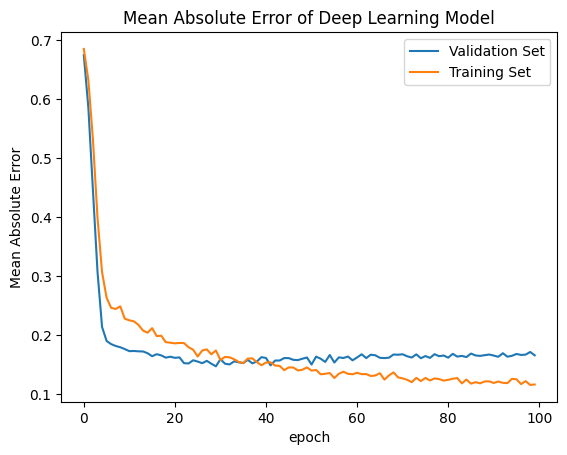

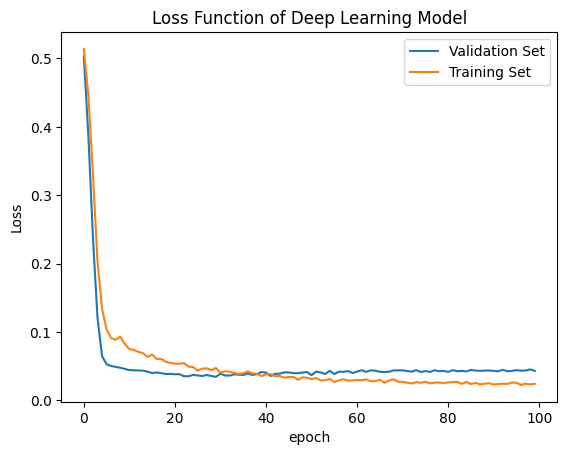

In [51]:
# summarize history for accuracy
plt.plot(history.history['val_mean_absolute_error'])
plt.plot(history.history['mean_absolute_error'])
plt.title('Mean Absolute Error of Deep Learning Model')
plt.ylabel('Mean Absolute Error')
plt.xlabel('epoch')
plt.legend(['Validation Set','Training Set',], loc='upper right')
plt.show()
# summarize history for loss
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])
plt.title('Loss Function of Deep Learning Model')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['Validation Set','Training Set'], loc='upper right')
plt.show()

#### Predict Results using Your Model
Here we use our test data again, but you'd likely want to apply this to other data. The inputs (and their format) must match the model that you trained above.

Below we provide some plots and summary statistics for evaluating true vs predicated values.
Try to create a model better than ours!

In [52]:
# make a prediction
predict = model.predict([np.array(X_test['transcriptomics'].tolist()),
     np.array(X_test['proteomics'].tolist()),
     np.array(X_test['fingerprint'].tolist())
    ])

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


In [53]:
new_df = pd.DataFrame({
    'Predicted Values': predict["priority"].tolist(),
    'True Values': y_test
})
new_df['Predicted Values'] = new_df['Predicted Values'].apply(lambda x: x[0] if isinstance(x, list) and len(x) == 1 else x)
sorted_df = new_df.sort_values(by='True Values', ascending=True)  # Change 'ascending' to False for descending order
sorted_df

,Predicted Values,True Values
445,0.482901,0.0714
78,0.646415,0.0963
81,0.356191,0.1431
164,0.391145,0.1547
155,0.433648,0.2638
...,...,...
655,0.929770,0.9842
296,0.762055,0.9842
357,0.818649,0.9872
136,0.759172,0.9972


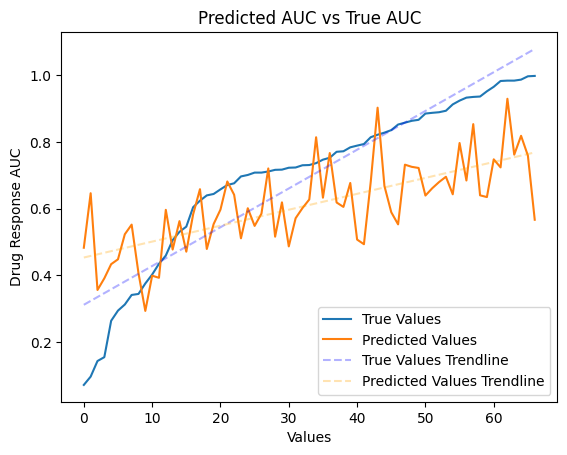

In [54]:
true_values = np.array(sorted_df["True Values"])
predicted_values = np.array(sorted_df["Predicted Values"])

# Plot the true values and predicted values
plt.plot(true_values)
plt.plot(predicted_values)

# Fit trendlines
true_values_trendline = LinearRegression().fit(np.arange(len(true_values)).reshape(-1, 1), true_values.reshape(-1, 1)).predict(np.arange(len(true_values)).reshape(-1, 1))
predicted_values_trendline = LinearRegression().fit(np.arange(len(predicted_values)).reshape(-1, 1), predicted_values.reshape(-1, 1)).predict(np.arange(len(predicted_values)).reshape(-1, 1))

# Plot trendlines
plt.plot(true_values_trendline, linestyle='--', color='blue', alpha=0.3)
plt.plot(predicted_values_trendline, linestyle='--', color='orange', alpha=0.3)

# Customize plot
plt.title('Predicted AUC vs True AUC')
plt.ylabel('Drug Response AUC')
plt.xlabel('Values')
plt.legend(['True Values', 'Predicted Values', 'True Values Trendline', 'Predicted Values Trendline'], loc='lower right')
plt.show()

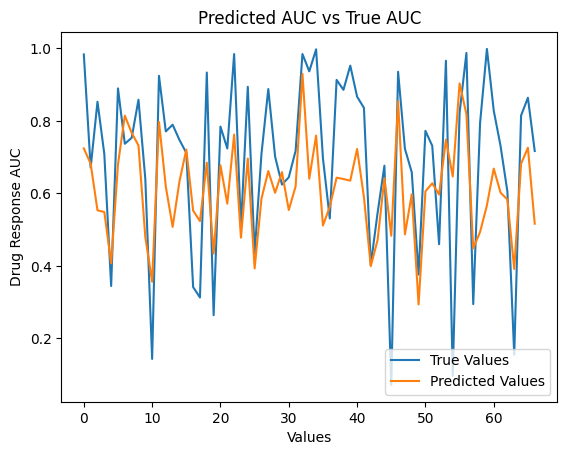

In [55]:
true_values = np.array(new_df["True Values"])
predicted_values = np.array(new_df["Predicted Values"])

# Plot the true values and predicted values
plt.plot(true_values)
plt.plot(predicted_values)

# Fit trendlines
true_values_trendline = LinearRegression().fit(np.arange(len(true_values)).reshape(-1, 1), true_values.reshape(-1, 1)).predict(np.arange(len(true_values)).reshape(-1, 1))
predicted_values_trendline = LinearRegression().fit(np.arange(len(predicted_values)).reshape(-1, 1), predicted_values.reshape(-1, 1)).predict(np.arange(len(predicted_values)).reshape(-1, 1))


# Customize plot
plt.title('Predicted AUC vs True AUC')
plt.ylabel('Drug Response AUC')
plt.xlabel('Values')
plt.legend(['True Values', 'Predicted Values', 'True Values Trendline', 'Predicted Values Trendline'], loc='lower right')
plt.show()

#### Calculate Summary Statistics 

In [ ]:
# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(new_df['True Values'], new_df['Predicted Values'])

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(new_df['True Values'], new_df['Predicted Values']))

# Calculate R-squared (R2) score
r2 = r2_score(new_df['True Values'], new_df['Predicted Values'])

summary_statistics = new_df.describe()

# Print the statistics
print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R2) Score:", r2)
print("\n")
# Print summary statistics
print(summary_statistics)

Mean Absolute Error (MAE): 0.162420572068798
Root Mean Squared Error (RMSE): 0.1939841660647883
R-squared (R2) Score: 0.33870446135832166


       Predicted Values  True Values
count         67.000000    67.000000
mean           0.611181     0.695534
std            0.130869     0.240344
min            0.293321     0.071400
25%            0.519710     0.614300
50%            0.618640     0.731000
75%            0.683152     0.876000
max            0.929770     0.998300


In [57]:
#Side by side comparison for first 50 values.
new_df[0:50]

,Predicted Values,True Values
281,0.723893,0.9831
286,0.681653,0.6710
473,0.553030,0.8525
227,0.548407,0.7083
436,0.406715,0.3443
360,0.679971,0.8894
647,0.814302,0.7367
465,0.766917,0.7529
618,0.732080,0.8581
90,0.479187,0.6399
